<a href="https://colab.research.google.com/github/sachinHansak/Generative-Adversarial-Network-GAN-Fake-Faces-Generation/blob/main/Generative_Adversarial_Network_Generate_fake_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sachinhansaka24","key":"65afe087f55a444af49b8e28c4ad32e0"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                     Most Streamed Spotify Songs 2023            47KB  2023-08-26 11:04:57          31017        934  1.0              
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset           146KB  2023-10-05 06:45:37           4145        101  1.0              
asaniczka/wages-by-education-in-the-usa-1973-2022           Wages by Education in the USA (1973-2022)    7KB  2023-10-09 09:43:40            944         29  1.0              
yakhyojon/air-quality-data                                  Air Quality Data                             7KB  2023-10-12 07:4

In [ ]:
! kaggle datasets download -d prasoonkottarathil/face-mask-lite-dataset

100% 23.3G/23.3G [19:25<00:00, 23.7MB/s]
100% 23.3G/23.3G [19:26<00:00, 21.4MB/s]


In [ ]:
! cp face-mask-lite-dataset.zip /content/drive/MyDrive/Facemask

In [ ]:
! unzip /content/drive/MyDrive/Facemask/face-mask-lite-dataset.zip

In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '/content/without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        if i == 'seed9090.png':
            break
        else:
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 91%|█████████ | 9090/10000 [07:05<00:42, 21.36it/s]


<ipython-input-16-d3d46399cfee>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


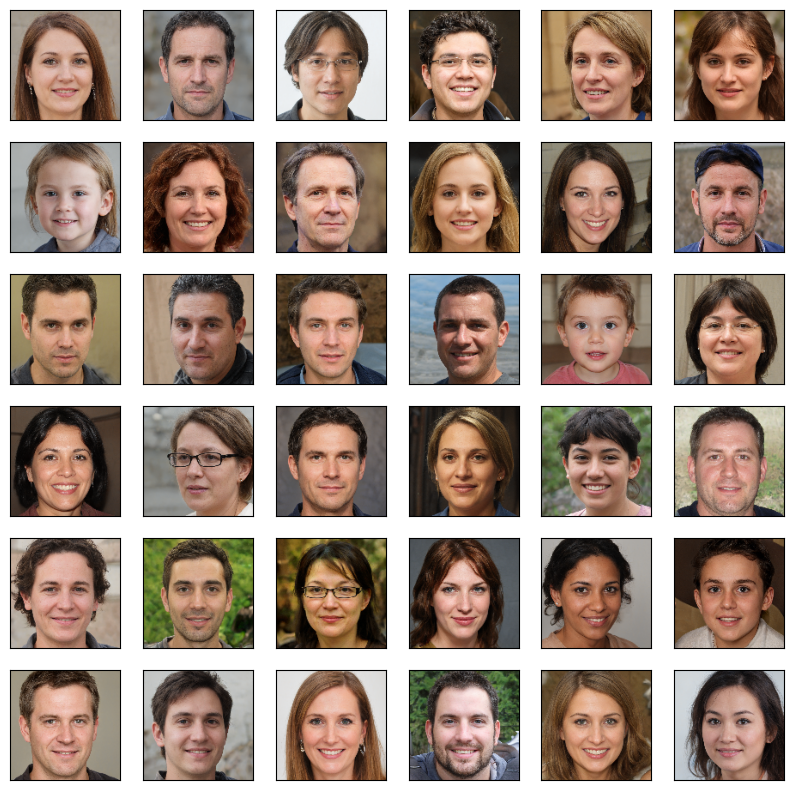

In [ ]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

In [ ]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [ ]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))



    return model

In [ ]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6144      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                        

In [ ]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_5 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)      

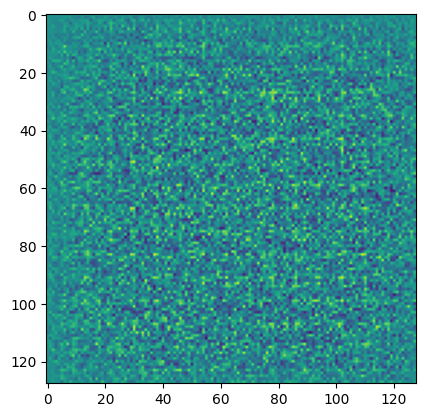

In [ ]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [ ]:
optimizer = tf.keras.optimizers.legacy.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [ ]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [ ]:
def plot_generated_images(square = 5, epochs = 0):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [ ]:
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))


In [ ]:
train(5,dataset)
# i had train model previously for more than 10 epochs so generated images are quiet good


Epoch : 1


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 Time:570.0
Generator Loss: 0.8270599842071533 Discriminator Loss: 1.5136618614196777

Epoch : 2
 Time:551.0
Generator Loss: 0.6603200435638428 Discriminator Loss: 1.2801815271377563

Epoch : 3
 Time:552.0
Generator Loss: 0.7093468904495239 Discriminator Loss: 1.2258727550506592

Epoch : 4
 Time:562.0
Generator Loss: 0.7365853190422058 Discriminator Loss: 1.2839828729629517

Epoch : 5
 Time:551.0
Generator Loss: 0.6256071329116821 Discriminator Loss: 1.2742102146148682


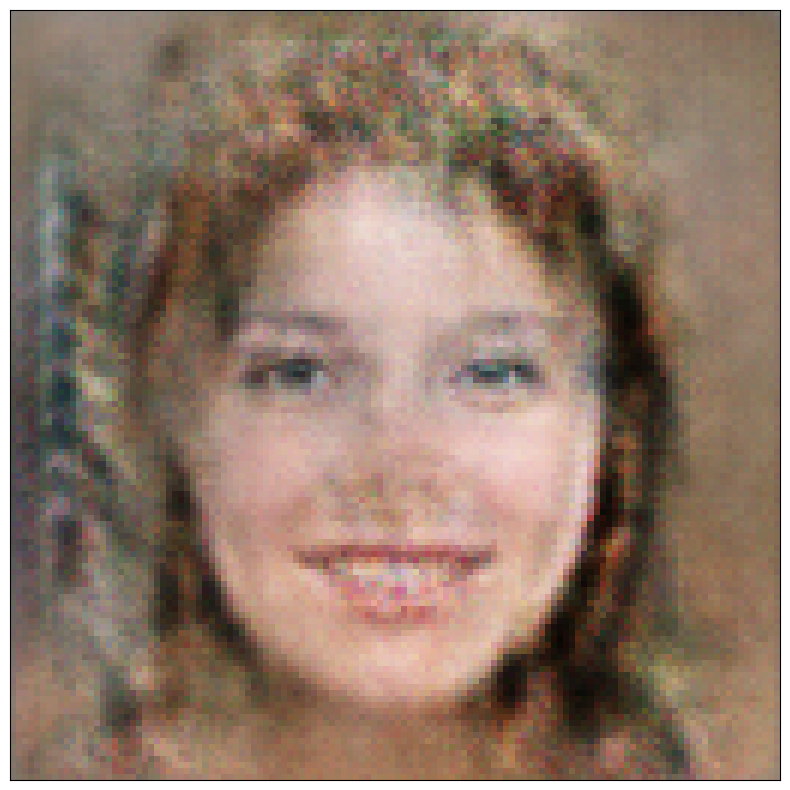

In [ ]:
plot_generated_images(1)

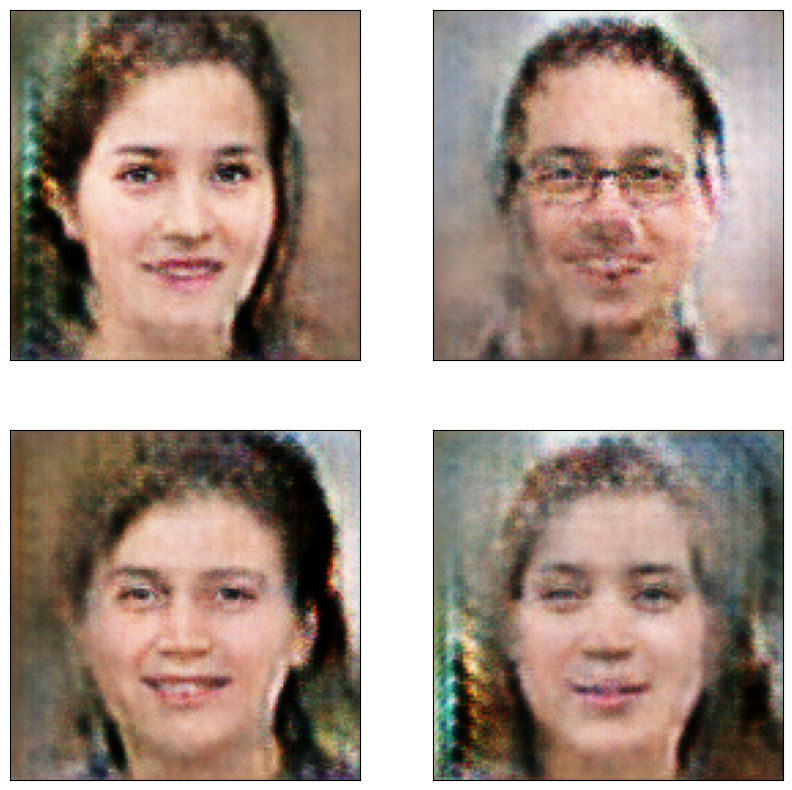

In [ ]:
plot_generated_images(2)

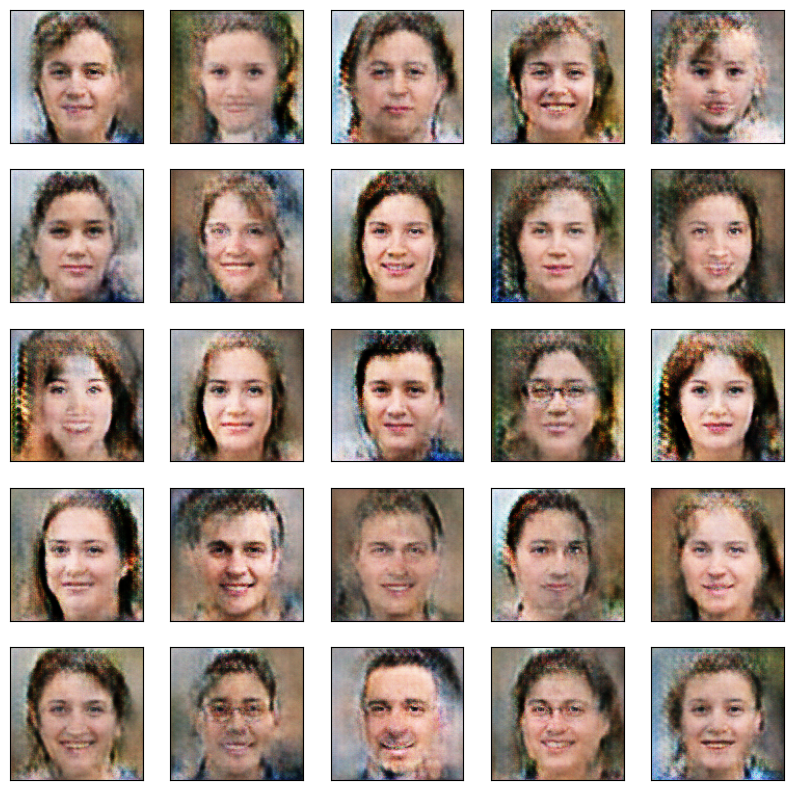

In [ ]:
plot_generated_images(5)

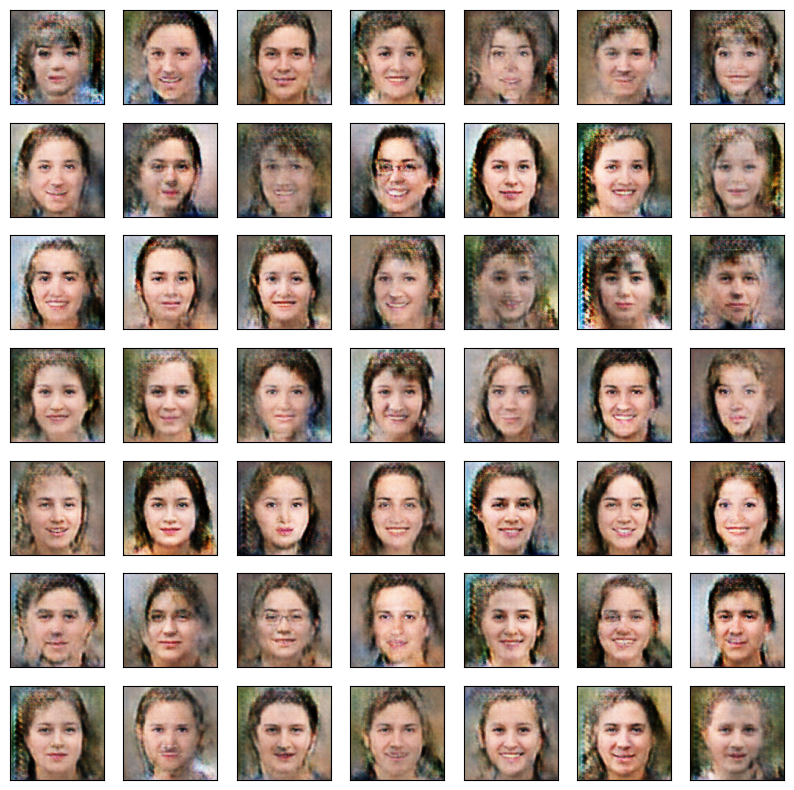

In [ ]:
plot_generated_images(7)

In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
